##### Get a boundary of data to read from, to match OSM region data

In [3]:
import pyrosm

In [4]:
# Get London's OpenStreetMap data
fp = pyrosm.get_data("London", update=True)
print(fp)
# Initialize the OSM object 
osm = pyrosm.OSM(fp)

Downloaded Protobuf data 'London.osm.pbf' (66.79 MB) to:
'/tmp/pyrosm/London.osm.pbf'
/tmp/pyrosm/London.osm.pbf


<AxesSubplot:>

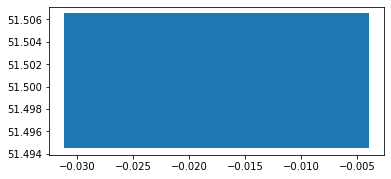

In [5]:
# # Read all boundaries using the default settings
# boundaries = osm.get_boundaries()

# # pick a small subset for testing
# boundary = osm.get_boundaries(name="London Borough of Tower Hamlets")
# boundary.plot()

import geopandas as gpd
from shapely.geometry import box

bbox = box(-0.0311018374,51.4945200196,-0.0039793398,51.5065151114)
boundary = gpd.GeoDataFrame({'geometry': bbox}, index=[0])
boundary.plot()

##### Load WorldPop Dataset and transform to match boundary

In [6]:
import geopandas as gpd
import rasterio
import rioxarray as rxr
from matplotlib import pyplot as plt

In [7]:
uk_wp = rxr.open_rasterio('../data/gbr_ppp_2020_UNadj_constrained.tif', masked=True).squeeze()
uk_wp.rio.crs  # make sure the crs is EPSG:4326 (WGS84) to match the unprojected OSM boundary

CRS.from_epsg(4326)

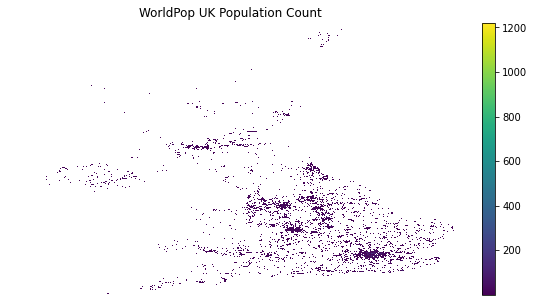

In [8]:
f, ax = plt.subplots(figsize=(10, 5))
uk_wp.plot.imshow()
ax.set(title="WorldPop UK Population Count")

ax.set_axis_off()
plt.show()

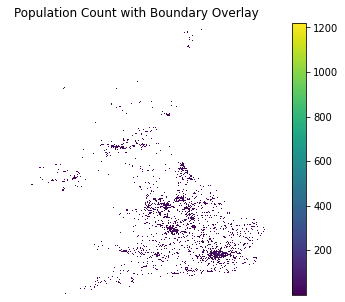

In [9]:
f, ax = plt.subplots(figsize=(10, 5))
uk_wp.plot.imshow(ax=ax)

boundary.plot(ax=ax, alpha=.8)
ax.set(title="Population Count with Boundary Overlay")

ax.set_axis_off()
plt.show()

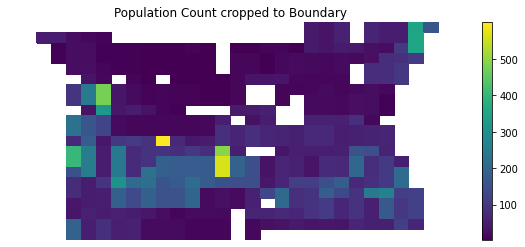

In [10]:
from shapely.geometry import mapping
from rasterio.crs import CRS

wp_clipped = uk_wp.rio.clip(boundary.geometry.apply(mapping))
wp_clipped = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700))

f, ax = plt.subplots(figsize=(10, 4))
wp_clipped.plot(ax=ax)
ax.set(title="Population Count cropped to Boundary")
ax.set_axis_off()
plt.show()

In [11]:
wp_clipped.sum()

<xarray.DataArray ()>
array(32729.11597729)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

In [12]:
# wp_clipped.rio.to_raster('./data/tower_hamlets_wp.tif')

In [14]:
import numpy as np
out_array = np.array(wp_clipped.data)

In [15]:
out_array[np.isnan(out_array)] = 0  # replace nan's with -1
out_array = out_array.astype(int)

In [16]:
np.savetxt('../data/sm_wp.txt', out_array, fmt='%d')

In [18]:
out_array.shape

(21, 30)